In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import nvgpu
import os

gpu = np.argmin([g["mem_used_percent"] for g in nvgpu.gpu_info()]) 
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu)

from src.experiments.Common import load_best_model

2025-04-15 13:23:33.864061: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-15 13:23:33.864083: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-15 13:23:33.865009: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-15 13:23:33.869588: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-15 13:23:34.770248: W tensorflow/compiler/tf2

Using TensorFlow backend


/media/nas/pperez/conda/ns3/envs/TAVtext/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Obtener los resultados en test del modelo (**para todo tipo de usuarios**)

In [ ]:
def obtain_results(datasets, models, users=0):
    '''users=0 todos, 1 solo conocidos, 2 desconocidos durante el entrenamiento'''
    results = []

    for dataset, subsets in datasets.items():
        for subset in subsets:
            for model in models:
                # Cargar configuración mejor modelo
                model_class = load_best_model(model=model, dataset=dataset, subset=subset, gpu=gpu)
                # Cargar el modelo entrenado
                model_class.train(dev=False, save_model=True)
                
                if users==1:
                    # Se buscan los usuarios de train y se dejan solo esos en test
                    train_dev_users = model_class.DATASET.DATA["TRAIN_DEV"].userId.unique()
                    model_class.DATASET.DATA["TEST"] = model_class.DATASET.DATA["TEST"][model_class.DATASET.DATA["TEST"]["userId"].isin(train_dev_users)]
                    model_class.DATASET.DATA["TEST"] = model_class.DATASET.DATA["TEST"].drop_duplicates(subset=["userId", "id_item"], keep='last', inplace=False)

                elif users==2:
                    # Se buscan los usuarios de train+dev y se eliminan de test
                    train_dev_users = model_class.DATASET.DATA["TRAIN_DEV"].userId.unique()
                    model_class.DATASET.DATA["TEST"] = model_class.DATASET.DATA["TEST"][~model_class.DATASET.DATA["TEST"]["userId"].isin(train_dev_users)]
                    model_class.DATASET.DATA["TEST"] = model_class.DATASET.DATA["TEST"].drop_duplicates(subset=["userId", "id_item"], keep='last', inplace=False)

                # Evaluar el modelo final
                result = model_class.evaluate(test=True, user_info=True)
                result["Model"] = model
                result["Set"] = dataset
                result["Subset"] = subset
                results.append(result.values[0])
                
    results = pd.DataFrame(results, columns=result.columns)
    # Poner nombres decentes para el artículo
    results["Set"].replace({"restaurants": "TAV-RSTS", "pois":"TAV-POIS", "amazon":"AM"}, inplace=True)
    results["Subset"].replace({"digital_music": "Music", "fashion":"Fashion", "gijon": "Gijón", "barcelona":"Barcelona", "madrid": "Madrid", "paris": "Paris", "newyorkcity": "New York", "london": "London"}, inplace=True)
    results["Model"].replace({"ATT2ITM": "AITRecX", "ATT2ITM_2": "AITRecX (NT)",}, inplace=True)

    return results

datasets = {"restaurants":["gijon", "barcelona", "madrid", "paris", "newyorkcity"],
            "pois":["barcelona", "madrid", "paris", "newyorkcity", "london"],
            "amazon":["fashion", "digital_music"]}

datasets = {"restaurants":[ "newyorkcity"]}
models = ["ATT2ITM", "ATT2ITM_2"]

results_all = obtain_results(datasets=datasets, models=models, users=0)
results_known = obtain_results(datasets=datasets, models=models, users=1)
results_unknown = obtain_results(datasets=datasets, models=models, users=2)

results = []
results_all["users"]="all"
results.extend(results_all.values)
results_known["users"]="known"
results.extend(results_known.values)
results_unknown["users"]="unknown"
results.extend(results_unknown.values)
results = pd.DataFrame(results, columns=results_all.columns)

## Crear tabla Latex

In [ ]:
def latex_table(results, metrics=["NDCG@10"], models = ['AITRecX', 'AITRecX (NT)']):
    result_df = []

    for metric in metrics:
        mres = results.pivot_table(index=[ "Set", "Subset"], columns=["users", "Model"])[metric].reset_index()
        mres["Metric"] = metric
        result_df.extend(mres.values)

    result_df = pd.DataFrame(result_df, columns=mres.columns)

    # Especificar el orden de los datos
    result_df['Set'] = pd.Categorical(result_df['Set'], ["AM", "TAV-POIS", "TAV-RSTS"])
    result_df['Subset'] = pd.Categorical(result_df['Subset'], ["Music", "Fashion", "Gijón", "Barcelona", "Madrid", "New York", "Paris", "London"])
    result_df['Metric'] = pd.Categorical(result_df['Metric'], metrics)

    result_df = result_df.pivot_table(index=["Set", "Subset", "Metric"])
    print(result_df.to_latex(float_format="%.3f"))
    # result_df[models].to_excel("trecx_known.xlsx")
    return result_df

metrics = ["NDCG@10"]
models = ['AITRecX', 'AITRecX (NT)']

table = latex_table(results, metrics=metrics, models=models)
table.to_excel("ablation_results.xlsx")

## Comparar gráficas y valores de "attention" para ambos modelos

Loading best ATT2ITM model: 8b74c00371d98f236fb265dd46b234c4
[WARNING] Model folder already exists...
[WARNING] Model weights are not loaded!
[INFO] Best epoch number: 1000
[INFO] Model already trained. Loading weights...
[QUERY] 'a cheese burger'
[PREPR]         [a cheese burger]
[TXT2ID]        [4, 170, 123]
[WORD FREQ]     [1898044, 57381, 78019]
El rango de valores de la matriz de atención para todas las palabras se mueve en el rango [-1.0,1.0].
[ERROR] Reparar y unificar la parte de selección de palabras relevantes
	[0.75] Shake Shack                  {'juiciness': 0.99993646, 'park': 0.99985105, 'fastfood': 0.9998154, 'madison': 0.9993195, 'growth': 0.99927986, 'skyscraper': 0.99862796, 'shackburger': 0.99753684, 'squirrel': 0.99752176, 'ciabatta': 0.9971996, 'chesse': 0.9968702}
		cheese 0.31
		burger 0.74
	[0.73] Corner Bistro                {'sneer': 0.9999743, 'burguer': 0.9998732, 'worn': 0.9979581, 'chuck': 0.9938817, 'neck': 0.9929096, 'grungy': 0.9891951, 'ia': 0.98410934

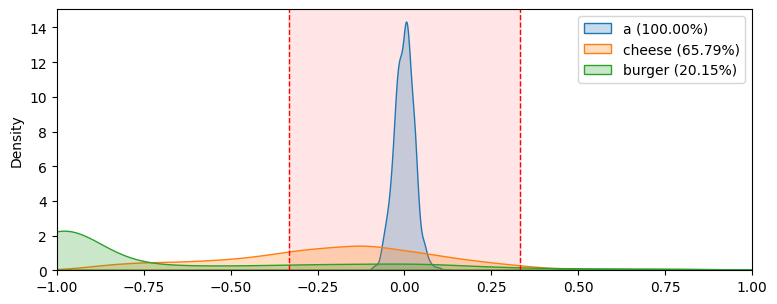

Loading best ATT2ITM_2 model: e3e91eb4584f0c13084dd5618b1a9f00
[WARNING] Model folder already exists...
[WARNING] Model weights are not loaded!
[INFO] Best epoch number: 557
[INFO] Model already trained. Loading weights...
[QUERY] 'a cheese burger'
[PREPR]         [a cheese burger]
[TXT2ID]        [4, 170, 123]
[WORD FREQ]     [1898044, 57381, 78019]
El rango de valores de la matriz de atención para todas las palabras se mueve en el rango [-43.2802848815918,9.986292839050293].
[ERROR] Reparar y unificar la parte de selección de palabras relevantes
	[0.75] Shake Shack         {'squirrel': 2.2383766, 'unconventional': 1.9516251, 'dishearten': 1.9453057, 'bette': 1.8826467, 'nycs': 1.8306098, 'disgraceful': 1.7436403, 'cam': 1.6551236, 'ironic': 1.6241292, 'macdonald': 1.5977515, 'umm': 1.5666823}
		cheese 0.33
		burger 0.70
	[0.73] Murray's Cheese Bar {'slate': 2.2830067, 'murray': 2.1786273, 'chess': 1.7924566, 'brine': 1.781582, 'tease': 1.7770816, 'curd': 1.5878065, 'differentiate': 1

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualizar_kde_intervalo_central(model, dataset, subset, text, gpu=None):
    # Cargar configuración del modelo
    model_class = load_best_model(model=model, dataset=dataset, subset=subset, gpu=gpu)
    
    # Cargar el modelo entrenado
    model_class.train(dev=False, save_model=True)
    
    # Evaluar un texto
    att_query, att_query_df, all_att = model_class.evaluate_text(text)

    # Gráfico KDE
    cm = 1 / 2.54  # cm a pulgadas
    plt.figure(figsize=(20 * cm, 8 * cm))

    if model == "ATT2ITM":
        lower = -1 / 3
        upper = 1 / 3
        
        # Dibujar el intervalo central
        plt.axvline(x=lower, color='red', linestyle='--', linewidth=1)
        plt.axvline(x=upper, color='red', linestyle='--', linewidth=1)
        plt.axvspan(lower, upper, color='red', alpha=0.1)

        for wid, word in enumerate(att_query_df["text"].values):           
            # Porcentaje de valores dentro del intervalo central
            valores = att_query[wid, :]
            porcentaje_central = np.mean((valores > lower) & (valores < upper)) * 100           
            kde = sns.kdeplot(att_query[wid, :], fill=True, label=f"{word} ({porcentaje_central:.2f}%)")

        kde.set_xlim([-1, 1])


    elif model == "ATT2ITM_2":

        for wid, word in enumerate(att_query_df["text"].values):

            min_val = att_query[wid, :].min()
            max_val = att_query[wid, :].max()
            lower = (2 * min_val + max_val) / 3
            upper = (min_val + 2 * max_val) / 3
            
            # Porcentaje de valores dentro del intervalo central
            valores = att_query[wid, :]
            porcentaje_central = np.mean((valores > lower) & (valores < upper)) * 100
            
            kde = sns.kdeplot(att_query[wid, :], fill=True, label=f"{word} ({porcentaje_central:.2f}%)")
            
            # Dibujar el intervalo central
            color = kde.get_lines()[-1].get_color()
            plt.axvline(x=lower, color=color, linestyle='--', linewidth=1)
            plt.axvline(x=upper, color=color, linestyle='--', linewidth=1)
            plt.axvspan(lower, upper, color=color, alpha=0.1)
            

        kde.set_xlim([att_query.min(), att_query.max()])

    else:
        raise ValueError(f"Modelo no soportado: {model}")

    plt.tight_layout()
    plt.legend()
    plt.savefig(f"{model}_plot.pdf")
    plt.show()

visualizar_kde_intervalo_central( model="ATT2ITM", dataset="restaurants", subset="newyorkcity", text="a cheese burger" )
visualizar_kde_intervalo_central( model="ATT2ITM_2", dataset="restaurants", subset="newyorkcity", text="a cheese burger" )

In [2]:
def evaluate_samples(datasets, models):

    for dataset, subsets in datasets.items():
        for subset in subsets:
            for model in models:
                # Cargar configuración mejor modelo
                model_class = load_best_model(model=model, dataset=dataset, subset=subset, gpu=gpu)
                # Cargar el modelo entrenado
                model_class.train(dev=False, save_model=True)
                # Evaluar un texto
                model_class.evaluate_text("no")

datasets = {"pois":["madrid", "paris", "newyorkcity"]}
models = ["ATT2ITM", "ATT2ITM_2"]

evaluate_samples(datasets=datasets, models=models)

Loading best ATT2ITM model: afe7526023b1827d88ecad6479de8971
[WARNING] Model folder already exists...
[WARNING] Model weights are not loaded!


2025-04-15 11:03:10.928666: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-15 11:03:10.928923: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-15 11:03:10.929106: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

[INFO] Best epoch number: 244
[INFO] Model already trained. Loading weights...
[QUERY] 'no'
[PREPR]         [no]
[TXT2ID]        [11]
[WORD FREQ]     [88862]
El rango de valores de la matriz de atención para todas las palabras se mueve en el rango [-1.0,0.9999994039535522].
[ERROR] Reparar y unificar la parte de selección de palabras relevantes


2025-04-15 11:03:12.256312: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


	[0.53] Parque de El Capricho                        {'osuna': 0.99927163, 'bunker': 0.9990261, 'capricho': 0.9983824, 'duquesa': 0.9964534, 'retirado': 0.9932595, 'comunion': 0.992307, 'casita': 0.9911413, 'cisn': 0.9891181, 'duque': 0.9873863, 'canal': 0.98469764}
	[0.52] Catedral de Sta María la Real de la Almudena {'catedral': 0.9971976, 'neogotico': 0.99526435, 'religioso': 0.99112713, 'cripta': 0.990997, 'misa': 0.98993, 'vidriera': 0.98922557, 'altar': 0.9882856, 'virgen': 0.9812937, 'catolico': 0.966136, 'techo': 0.9652268}
	[0.52] Faunia                                       {'pinguino': 0.9992354, 'faunia': 0.9991275, 'mariposa': 0.9953337, 'olivo': 0.99488556, 'ecosistema': 0.99199045, 'selva': 0.98955804, 'habitats': 0.9862815, 'jungla': 0.98550475, 'marino': 0.9799365, 'habitat': 0.9708955}
	[0.52] Museo del Prado                              {'ingr': 0.9997906, 'hilandera': 0.9986727, 'velasquez': 0.99855596, 'bosco': 0.9982289, 'velazquez': 0.9980678, 'menina': 0.9980078